In [1]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data

### Read In Edge List and Transpose into COO Format

In [2]:
with open('edge_list/edge_index.txt') as edge_file:
    edges = []
    for line in edge_file.readlines():
        u, v, d = line.split()
        edges.append([int(u),int(v)])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

### Read in Data Matrix and Convert to Torch Tensor

$n x m$ matrix where $n$ is the number of states and $m$ is the number of search terms(features).

In [3]:
!ls hopkins_data/cleaned

2020-01-22.csv 2020-02-09.csv 2020-02-27.csv 2020-03-16.csv 2020-04-03.csv
2020-01-23.csv 2020-02-10.csv 2020-02-28.csv 2020-03-17.csv 2020-04-04.csv
2020-01-24.csv 2020-02-11.csv 2020-02-29.csv 2020-03-18.csv 2020-04-05.csv
2020-01-25.csv 2020-02-12.csv 2020-03-01.csv 2020-03-19.csv 2020-04-06.csv
2020-01-26.csv 2020-02-13.csv 2020-03-02.csv 2020-03-20.csv 2020-04-07.csv
2020-01-27.csv 2020-02-14.csv 2020-03-03.csv 2020-03-21.csv 2020-04-08.csv
2020-01-28.csv 2020-02-15.csv 2020-03-04.csv 2020-03-22.csv 2020-04-09.csv
2020-01-29.csv 2020-02-16.csv 2020-03-05.csv 2020-03-23.csv 2020-04-10.csv
2020-01-30.csv 2020-02-17.csv 2020-03-06.csv 2020-03-24.csv 2020-04-11.csv
2020-01-31.csv 2020-02-18.csv 2020-03-07.csv 2020-03-25.csv 2020-04-12.csv
2020-02-01.csv 2020-02-19.csv 2020-03-08.csv 2020-03-26.csv 2020-04-13.csv
2020-02-02.csv 2020-02-20.csv 2020-03-09.csv 2020-03-27.csv 2020-04-14.csv
2020-02-03.csv 2020-02-21.csv 2020-03-10.csv 2020-03-28.csv 2020-04-15.csv
2020-02-04.csv 2020-02-22

In [4]:
nodes_props = np.loadtxt('./datesprepped/2020-01-31.csv')
nodes_props

array([[ 0.,  0.,  0., ...,  0., 11.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 14.,  0., ...,  0., 10.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Get Hopkins Data Labels

In [5]:
# y = np.round(np.random.random(size=[51,1]) * 10) # randomly generate some cases for now
# y = torch.tensor(y, dtype=torch.float)
with open('./hopkins_data/cleaned/2020-01-31.csv') as fy:
    y_arr = [int(line.split(',')[0]) for line in fy.readlines()]
y = torch.tensor(y_arr, dtype=torch.float).reshape([51, 1])

### Create Data Object

In [6]:
x = torch.tensor(nodes_props.tolist(), dtype=torch.float)
edge_index = edge_index
data = Data(x=x, y=y, edge_index=edge_index)

In [7]:
data.num_node_features

3243

### Creating Dataloader

Now that we've created a single data object as an example we need to create a torch dataloader. This way we can batch multiple nodes together.

In [11]:
import os.path as osp
import os
from datetime import datetime, timedelta
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader


class COVIDSearchTerms(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(COVIDSearchTerms, self).__init__(root, transform, pre_transform)
        self.node_files = []
        self.target_files = []

    @property
    def raw_file_names(self):
        self.node_files = ['x/' + f for f in os.listdir('raw/x/')]
        self.node_files.sort(
            key = lambda date: datetime.strptime(date.split('/')[-1].split('.')[0], '%Y-%m-%d')
        )
        # ensure that we only grab targets for dates we have
        self.target_files = [
            'y/' + f for f in
            list(set(os.listdir('raw/y/')) & set(os.listdir('raw/x/')))
        ]

        self.target_files.sort(
            key = lambda date: datetime.strptime(date.split('/')[-1].split('.')[0], '%Y-%m-%d')
        )

        return self.node_files + self.target_files

    @property
    def processed_file_names(self):
        dates = os.listdir('raw/y/')
        return dates

    def download(self):
        pass
        # Download to `self.raw_dir`.

    def process(self):
        with open('edge_list/edge_index.txt') as edge_file:
            edges = []
            for line in edge_file.readlines():
                u, v, d = line.split()
                edges.append([int(u),int(v)])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        
        i = 0
        for node_file in self.node_files:
            date = node_file.split('/')[-1].split('.')[0]
            week_forward = datetime.strptime(date, '%Y-%m-%d') + timedelta(weeks=1)
            x = torch.tensor(np.loadtxt('raw/' + node_file).tolist(), dtype=torch.float)
            
            with open('raw/y/' + date + '.csv') as fy:
                hk_data_arr = [int(line.split(',')[0]) for line in fy.readlines()]
            hk_data_arr = torch.tensor(hk_data_arr, dtype=torch.float).reshape([51, 1])
            
            x = torch.cat([x, hk_data_arr], dim=1)
            
            with open('raw/y/' + week_forward.strftime('%Y-%m-%d') + '.csv') as fy:
                y_arr = [int(line.split(',')[0]) for line in fy.readlines()]
            y = torch.tensor(y_arr, dtype=torch.float).reshape([1, 51])
            edge_index = edge_index
            # Read data from `raw_path`.
            data = Data(x=x, y=y, edge_index=edge_index)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)
            torch.save(data, osp.join(self.processed_dir, 'data-{}.pt'.format(i)))
            i = i + 1

    def len(self):
        return 57

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data-{}.pt'.format(idx)))
        return data

### Example Network Structure

In [12]:
'''
    Network structure taken from example:
    https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
'''

feature_dim = data.num_node_features # should be 3243 for the number of queries
from torch.nn import LSTM
from torch_geometric.nn import TopKPooling, SAGEConv, GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 6 layers down convolutons?
        self.conv1 = GCNConv(feature_dim + 1, 2000)
        self.conv2 = GCNConv(2000, 1000)
        self.conv3 = GCNConv(1000, 500)
        self.conv4 = GCNConv(500, 100)
        self.conv5 = GCNConv(100, 10)
        # Reveals a [51, 1] tensor where the 2nd dimensions is the number of cases?
        self.conv6 = GCNConv(10, 1)
        
#         self.lin1 = torch.nn.Linear(10, 51)
#         self.act1 = torch.nn.ReLU()
        
#         self.lstm = LSTM(input_size=51, hidden_size=51, num_layers=3)
        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        nm = torch.norm(x).detach()
        x = x.div(nm.expand_as(x))
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv6(x, edge_index)
        
#         x = self.lin1(x)
#         x = self.act1(x)

#         x, _ = self.lstm(x.view(1, 51, 51))
        
        return x.t()

### Example feed forward of the network

In [17]:
def train():
    model.train()

    losses = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        print(loss)
        losses.append(loss)
        loss.backward()
#         loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return losses

batch_size=1
dataset = COVIDSearchTerms('.')
train_data = dataset[:50]
valid_data = dataset[50:]
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.L1Loss()
train_loader = DataLoader(train_data, batch_size=batch_size)


losses = []
i = 1
for epoch in range(5):
    losses.append(train())
    print((i / 10) * 100)
    i = i + 1

Processing...
Done!
tensor(0.2387, grad_fn=<L1LossBackward>)
tensor(0.2896, grad_fn=<L1LossBackward>)
tensor(0.3283, grad_fn=<L1LossBackward>)
tensor(0.3515, grad_fn=<L1LossBackward>)
tensor(0.3462, grad_fn=<L1LossBackward>)
tensor(0.3135, grad_fn=<L1LossBackward>)
tensor(0.2992, grad_fn=<L1LossBackward>)
tensor(0.2957, grad_fn=<L1LossBackward>)
tensor(0.3189, grad_fn=<L1LossBackward>)
tensor(0.6870, grad_fn=<L1LossBackward>)
tensor(0.6963, grad_fn=<L1LossBackward>)
tensor(0.6878, grad_fn=<L1LossBackward>)
tensor(0.3345, grad_fn=<L1LossBackward>)
tensor(0.3375, grad_fn=<L1LossBackward>)
tensor(0.3339, grad_fn=<L1LossBackward>)
tensor(0.3538, grad_fn=<L1LossBackward>)
tensor(0.3532, grad_fn=<L1LossBackward>)
tensor(0.5105, grad_fn=<L1LossBackward>)
tensor(0.6285, grad_fn=<L1LossBackward>)
tensor(1.0989, grad_fn=<L1LossBackward>)
tensor(1.5734, grad_fn=<L1LossBackward>)
tensor(2.1571, grad_fn=<L1LossBackward>)
tensor(3.4907, grad_fn=<L1LossBackward>)
tensor(4.6278, grad_fn=<L1LossBackwar

tensor(2748.8496, grad_fn=<L1LossBackward>)
tensor(3146.3430, grad_fn=<L1LossBackward>)
tensor(3664.8342, grad_fn=<L1LossBackward>)
tensor(4152.1445, grad_fn=<L1LossBackward>)
tensor(4732.6455, grad_fn=<L1LossBackward>)
40.0
tensor(39.1633, grad_fn=<L1LossBackward>)
tensor(61.8336, grad_fn=<L1LossBackward>)
tensor(24.4913, grad_fn=<L1LossBackward>)
tensor(16.0267, grad_fn=<L1LossBackward>)
tensor(11.3836, grad_fn=<L1LossBackward>)
tensor(4.4605, grad_fn=<L1LossBackward>)
tensor(3.2811, grad_fn=<L1LossBackward>)
tensor(1.5604, grad_fn=<L1LossBackward>)
tensor(0.7950, grad_fn=<L1LossBackward>)
tensor(0.8985, grad_fn=<L1LossBackward>)
tensor(0.9170, grad_fn=<L1LossBackward>)
tensor(0.8677, grad_fn=<L1LossBackward>)
tensor(0.5194, grad_fn=<L1LossBackward>)
tensor(0.5167, grad_fn=<L1LossBackward>)
tensor(0.5150, grad_fn=<L1LossBackward>)
tensor(0.5279, grad_fn=<L1LossBackward>)
tensor(0.5078, grad_fn=<L1LossBackward>)
tensor(0.6599, grad_fn=<L1LossBackward>)
tensor(0.7600, grad_fn=<L1LossBa

In [18]:

validation_loader = DataLoader(valid_data, batch_size=batch_size)
for data in validation_loader:
    output = model(data)
    label = data.y.to(device)
    print(output, label)

tensor([[0.3023, 0.3024, 0.3024, 0.3024, 0.3024, 0.3024, 0.3000, 0.3010, 0.3024,
         0.3022, 0.3022, 0.3024, 0.3024, 0.3024, 0.3024, 0.3024, 0.3024, 0.3024,
         0.3024, 0.3024, 0.3010, 0.3000, 0.3024, 0.3024, 0.3022, 0.3024, 0.3024,
         0.3024, 0.3024, 0.3024, 0.3004, 0.3024, 0.3000, 0.3024, 0.3024, 0.3024,
         0.3024, 0.3024, 0.3010, 0.2990, 0.3024, 0.3024, 0.3023, 0.3024, 0.3024,
         0.3024, 0.3024, 0.3024, 0.3024, 0.3024, 0.3024]], grad_fn=<TBackward>) tensor([[  1495.,    157.,   1937.,    704.,  12004.,   3742.,   4914.,    450.,
            757.,  10268.,   5831.,    319.,    891.,   8904.,   3437.,    699.,
            629.,    770.,  10297.,    432.,   2758.,  10402.,  12744.,    788.,
           1358.,   1864.,    243.,    279.,   1514.,    479.,  29895.,    534.,
         102987.,   2251.,    173.,   3312.,    990.,    899.,   8570.,    711.,
           1700.,    187.,   3067.,   5734.,   1255.,    389.,   2249.,   6846.,
            237.,   2012.,   

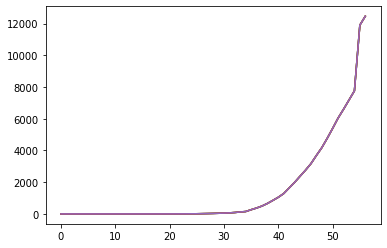

In [198]:
import matplotlib.pyplot as plt

for i in losses:
    plt.plot(i)

### Old training example

In [38]:
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.MSELoss()


# Fit?
model.train()

for i in range(0,500):
    data = data.to(device)
    optimizer.zero_grad()
    output = model(data)
    label = data.y.to(device)
    loss = crit(output, label)
    print(loss)
    loss.backward()
    loss_all = loss.item()
    optimizer.step()

optimizer.zero_grad()
output = model(data)
loss = crit(output, label)
print(output)
print(loss)

tensor(0.6053, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBac

tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBac

tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBackward>)
tensor(0.1961, grad_fn=<MseLossBac

In [131]:
'''
    Network structure taken from example:
    https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
'''

feature_dim = data.num_node_features # should be 3243 for the number of queries
from torch_geometric.nn import TopKPooling, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Replaced all instances of the dim 128 with 1500
        self.conv1 = SAGEConv(feature_dim + 1, 1000)
        self.pool1 = TopKPooling(1000, ratio=0.8)
        self.conv2 = SAGEConv(1000, 1000)
        self.pool2 = TopKPooling(1000, ratio=0.8)
        self.conv3 = SAGEConv(1000, 1000)
        self.pool3 = TopKPooling(1000, ratio=0.8)
# We kind of did our own embeddings....
#         self.item_embedding = torch.nn.Embedding(num_embeddings=df.item_id.max() +1, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(2000, 1000)
#         self.lin1 = torch.nn.Linear(feature_dim, 1500)
        self.lin2 = torch.nn.Linear(1000, 500)
        self.lin3 = torch.nn.Linear(500, 250)
        self.lin4 = torch.nn.Linear(250, 51)
#         self.bn1 = torch.nn.BatchNorm1d(500)
#         self.bn2 = torch.nn.BatchNorm1d(125)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()
        self.act3 = torch.nn.ReLU()
        self.act4 = torch.nn.ReLU()
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
    
        x = F.relu(self.conv1(x, edge_index))

        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3
        
        x = self.lin1(x)
        x = self.act1(x)        
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)
        # Using the third layer in a traditional sense?
        x = self.lin3(x)
        x = self.act3(x)
        x = self.lin4(x)
        x = self.act4(x)
        # We need to change the ouput to continous rather than discrete
#         x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

### Example work for earlier session with torch geo

In [2]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [60]:
data = Data(x=x, edge_index=edge_index, y=y)

In [61]:
data.num_node_features

2

In [73]:
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(2, 1)
        self.lin1 = torch.nn.Linear(1, 1)
        self.act1 = torch.nn.ReLU()
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.relu(self.conv1(x, edge_index))
        x = self.lin1(x)
        x = self.act1(x)
        return x
        

In [91]:
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.MSELoss()


# Fit?
model.train()

for i in range(0,1000):
    data = data.to(device)
    optimizer.zero_grad()
    output = model(data)
    print(output, loss)
    label = data.y.to(device)
    loss = crit(output, label)
    loss.backward()
    loss_all = loss.item()
    optimizer.step()

optimizer.zero_grad()
output = model(data)
loss = crit(output, label)
print(output)
print(loss)

tensor([[0.6239],
        [1.3403],
        [1.2010],
        [0.7558]], grad_fn=<ReluBackward0>) tensor(0.2530, grad_fn=<MseLossBackward>)
tensor([[0.5991],
        [1.2942],
        [1.1583],
        [0.7262]], grad_fn=<ReluBackward0>) tensor(0.5696, grad_fn=<MseLossBackward>)
tensor([[0.5746],
        [1.2488],
        [1.1163],
        [0.6971]], grad_fn=<ReluBackward0>) tensor(0.5312, grad_fn=<MseLossBackward>)
tensor([[0.5506],
        [1.2043],
        [1.0752],
        [0.6685]], grad_fn=<ReluBackward0>) tensor(0.4962, grad_fn=<MseLossBackward>)
tensor([[0.5271],
        [1.1608],
        [1.0349],
        [0.6406]], grad_fn=<ReluBackward0>) tensor(0.4645, grad_fn=<MseLossBackward>)
tensor([[0.5042],
        [1.1183],
        [0.9957],
        [0.6134]], grad_fn=<ReluBackward0>) tensor(0.4358, grad_fn=<MseLossBackward>)
tensor([[0.4818],
        [1.0770],
        [0.9576],
        [0.5870]], grad_fn=<ReluBackward0>) tensor(0.4102, grad_fn=<MseLossBackward>)
tensor([[0.4601],
  

tensor([[0.2908],
        [0.6438],
        [0.5972],
        [0.3822]], grad_fn=<ReluBackward0>) tensor(0.2721, grad_fn=<MseLossBackward>)
tensor([[0.2904],
        [0.6417],
        [0.5958],
        [0.3821]], grad_fn=<ReluBackward0>) tensor(0.2719, grad_fn=<MseLossBackward>)
tensor([[0.2900],
        [0.6395],
        [0.5945],
        [0.3819]], grad_fn=<ReluBackward0>) tensor(0.2718, grad_fn=<MseLossBackward>)
tensor([[0.2897],
        [0.6374],
        [0.5931],
        [0.3818]], grad_fn=<ReluBackward0>) tensor(0.2716, grad_fn=<MseLossBackward>)
tensor([[0.2893],
        [0.6353],
        [0.5918],
        [0.3816]], grad_fn=<ReluBackward0>) tensor(0.2714, grad_fn=<MseLossBackward>)
tensor([[0.2890],
        [0.6332],
        [0.5905],
        [0.3815]], grad_fn=<ReluBackward0>) tensor(0.2713, grad_fn=<MseLossBackward>)
tensor([[0.2887],
        [0.6312],
        [0.5893],
        [0.3814]], grad_fn=<ReluBackward0>) tensor(0.2711, grad_fn=<MseLossBackward>)
tensor([[0.2885],
  

        [0.4220]], grad_fn=<ReluBackward0>) tensor(0.2636, grad_fn=<MseLossBackward>)
tensor([[0.3173],
        [0.5882],
        [0.5816],
        [0.4226]], grad_fn=<ReluBackward0>) tensor(0.2635, grad_fn=<MseLossBackward>)
tensor([[0.3178],
        [0.5877],
        [0.5815],
        [0.4231]], grad_fn=<ReluBackward0>) tensor(0.2635, grad_fn=<MseLossBackward>)
tensor([[0.3183],
        [0.5872],
        [0.5814],
        [0.4237]], grad_fn=<ReluBackward0>) tensor(0.2634, grad_fn=<MseLossBackward>)
tensor([[0.3188],
        [0.5867],
        [0.5813],
        [0.4242]], grad_fn=<ReluBackward0>) tensor(0.2633, grad_fn=<MseLossBackward>)
tensor([[0.3193],
        [0.5862],
        [0.5812],
        [0.4248]], grad_fn=<ReluBackward0>) tensor(0.2632, grad_fn=<MseLossBackward>)
tensor([[0.3198],
        [0.5858],
        [0.5811],
        [0.4253]], grad_fn=<ReluBackward0>) tensor(0.2631, grad_fn=<MseLossBackward>)
tensor([[0.3203],
        [0.5853],
        [0.5810],
        [0.4258]], g

tensor([[0.3578],
        [0.5554],
        [0.5690],
        [0.4568]], grad_fn=<ReluBackward0>) tensor(0.2575, grad_fn=<MseLossBackward>)
tensor([[0.3583],
        [0.5551],
        [0.5688],
        [0.4571]], grad_fn=<ReluBackward0>) tensor(0.2575, grad_fn=<MseLossBackward>)
tensor([[0.3587],
        [0.5548],
        [0.5687],
        [0.4573]], grad_fn=<ReluBackward0>) tensor(0.2574, grad_fn=<MseLossBackward>)
tensor([[0.3591],
        [0.5545],
        [0.5685],
        [0.4576]], grad_fn=<ReluBackward0>) tensor(0.2574, grad_fn=<MseLossBackward>)
tensor([[0.3596],
        [0.5543],
        [0.5683],
        [0.4579]], grad_fn=<ReluBackward0>) tensor(0.2573, grad_fn=<MseLossBackward>)
tensor([[0.3600],
        [0.5540],
        [0.5682],
        [0.4582]], grad_fn=<ReluBackward0>) tensor(0.2573, grad_fn=<MseLossBackward>)
tensor([[0.3605],
        [0.5537],
        [0.5680],
        [0.4584]], grad_fn=<ReluBackward0>) tensor(0.2572, grad_fn=<MseLossBackward>)
tensor([[0.3609],
  

tensor([[0.3899],
        [0.5380],
        [0.5559],
        [0.4732]], grad_fn=<ReluBackward0>) tensor(0.2544, grad_fn=<MseLossBackward>)
tensor([[0.3902],
        [0.5378],
        [0.5557],
        [0.4734]], grad_fn=<ReluBackward0>) tensor(0.2544, grad_fn=<MseLossBackward>)
tensor([[0.3906],
        [0.5377],
        [0.5555],
        [0.4736]], grad_fn=<ReluBackward0>) tensor(0.2543, grad_fn=<MseLossBackward>)
tensor([[0.3910],
        [0.5375],
        [0.5554],
        [0.4737]], grad_fn=<ReluBackward0>) tensor(0.2543, grad_fn=<MseLossBackward>)
tensor([[0.3913],
        [0.5373],
        [0.5552],
        [0.4739]], grad_fn=<ReluBackward0>) tensor(0.2543, grad_fn=<MseLossBackward>)
tensor([[0.3917],
        [0.5372],
        [0.5551],
        [0.4740]], grad_fn=<ReluBackward0>) tensor(0.2542, grad_fn=<MseLossBackward>)
tensor([[0.3921],
        [0.5370],
        [0.5549],
        [0.4742]], grad_fn=<ReluBackward0>) tensor(0.2542, grad_fn=<MseLossBackward>)
tensor([[0.3924],
  

tensor([[0.4144],
        [0.5277],
        [0.5447],
        [0.4822]], grad_fn=<ReluBackward0>) tensor(0.2526, grad_fn=<MseLossBackward>)
tensor([[0.4147],
        [0.5276],
        [0.5446],
        [0.4823]], grad_fn=<ReluBackward0>) tensor(0.2526, grad_fn=<MseLossBackward>)
tensor([[0.4150],
        [0.5275],
        [0.5444],
        [0.4824]], grad_fn=<ReluBackward0>) tensor(0.2526, grad_fn=<MseLossBackward>)
tensor([[0.4153],
        [0.5274],
        [0.5443],
        [0.4825]], grad_fn=<ReluBackward0>) tensor(0.2526, grad_fn=<MseLossBackward>)
tensor([[0.4156],
        [0.5273],
        [0.5442],
        [0.4825]], grad_fn=<ReluBackward0>) tensor(0.2525, grad_fn=<MseLossBackward>)
tensor([[0.4159],
        [0.5272],
        [0.5440],
        [0.4826]], grad_fn=<ReluBackward0>) tensor(0.2525, grad_fn=<MseLossBackward>)
tensor([[0.4162],
        [0.5271],
        [0.5439],
        [0.4827]], grad_fn=<ReluBackward0>) tensor(0.2525, grad_fn=<MseLossBackward>)
tensor([[0.4165],
  

tensor([[0.4358],
        [0.5201],
        [0.5344],
        [0.4882]], grad_fn=<ReluBackward0>) tensor(0.2515, grad_fn=<MseLossBackward>)
tensor([[0.4360],
        [0.5200],
        [0.5342],
        [0.4883]], grad_fn=<ReluBackward0>) tensor(0.2515, grad_fn=<MseLossBackward>)
tensor([[0.4362],
        [0.5199],
        [0.5341],
        [0.4883]], grad_fn=<ReluBackward0>) tensor(0.2515, grad_fn=<MseLossBackward>)
tensor([[0.4365],
        [0.5198],
        [0.5340],
        [0.4884]], grad_fn=<ReluBackward0>) tensor(0.2514, grad_fn=<MseLossBackward>)
tensor([[0.4367],
        [0.5198],
        [0.5339],
        [0.4884]], grad_fn=<ReluBackward0>) tensor(0.2514, grad_fn=<MseLossBackward>)
tensor([[0.4369],
        [0.5197],
        [0.5338],
        [0.4885]], grad_fn=<ReluBackward0>) tensor(0.2514, grad_fn=<MseLossBackward>)
tensor([[0.4371],
        [0.5196],
        [0.5337],
        [0.4885]], grad_fn=<ReluBackward0>) tensor(0.2514, grad_fn=<MseLossBackward>)
tensor([[0.4374],
  

tensor([[0.4507],
        [0.5151],
        [0.5268],
        [0.4917]], grad_fn=<ReluBackward0>) tensor(0.2509, grad_fn=<MseLossBackward>)
tensor([[0.4509],
        [0.5151],
        [0.5267],
        [0.4917]], grad_fn=<ReluBackward0>) tensor(0.2509, grad_fn=<MseLossBackward>)
tensor([[0.4511],
        [0.5150],
        [0.5266],
        [0.4917]], grad_fn=<ReluBackward0>) tensor(0.2509, grad_fn=<MseLossBackward>)
tensor([[0.4513],
        [0.5150],
        [0.5265],
        [0.4918]], grad_fn=<ReluBackward0>) tensor(0.2508, grad_fn=<MseLossBackward>)
tensor([[0.4514],
        [0.5149],
        [0.5264],
        [0.4918]], grad_fn=<ReluBackward0>) tensor(0.2508, grad_fn=<MseLossBackward>)
tensor([[0.4516],
        [0.5149],
        [0.5263],
        [0.4918]], grad_fn=<ReluBackward0>) tensor(0.2508, grad_fn=<MseLossBackward>)
tensor([[0.4518],
        [0.5148],
        [0.5262],
        [0.4919]], grad_fn=<ReluBackward0>) tensor(0.2508, grad_fn=<MseLossBackward>)
tensor([[0.4520],
  

        [0.4940]], grad_fn=<ReluBackward0>) tensor(0.2505, grad_fn=<MseLossBackward>)
tensor([[0.4624],
        [0.5115],
        [0.5207],
        [0.4940]], grad_fn=<ReluBackward0>) tensor(0.2505, grad_fn=<MseLossBackward>)
tensor([[0.4626],
        [0.5114],
        [0.5206],
        [0.4940]], grad_fn=<ReluBackward0>) tensor(0.2505, grad_fn=<MseLossBackward>)
tensor([[0.4627],
        [0.5114],
        [0.5205],
        [0.4941]], grad_fn=<ReluBackward0>) tensor(0.2505, grad_fn=<MseLossBackward>)
tensor([[0.4629],
        [0.5113],
        [0.5204],
        [0.4941]], grad_fn=<ReluBackward0>) tensor(0.2505, grad_fn=<MseLossBackward>)
tensor([[0.4630],
        [0.5113],
        [0.5204],
        [0.4941]], grad_fn=<ReluBackward0>) tensor(0.2505, grad_fn=<MseLossBackward>)
tensor([[0.4631],
        [0.5112],
        [0.5203],
        [0.4941]], grad_fn=<ReluBackward0>) tensor(0.2505, grad_fn=<MseLossBackward>)
tensor([[0.4633],
        [0.5112],
        [0.5202],
        [0.4942]], g

tensor([[0.4719],
        [0.5085],
        [0.5156],
        [0.4957]], grad_fn=<ReluBackward0>) tensor(0.2503, grad_fn=<MseLossBackward>)
tensor([[0.4720],
        [0.5085],
        [0.5155],
        [0.4957]], grad_fn=<ReluBackward0>) tensor(0.2503, grad_fn=<MseLossBackward>)
tensor([[0.4721],
        [0.5085],
        [0.5155],
        [0.4957]], grad_fn=<ReluBackward0>) tensor(0.2503, grad_fn=<MseLossBackward>)
tensor([[0.4723],
        [0.5084],
        [0.5154],
        [0.4958]], grad_fn=<ReluBackward0>) tensor(0.2503, grad_fn=<MseLossBackward>)
tensor([[0.4724],
        [0.5084],
        [0.5153],
        [0.4958]], grad_fn=<ReluBackward0>) tensor(0.2503, grad_fn=<MseLossBackward>)
tensor([[0.4725],
        [0.5084],
        [0.5153],
        [0.4958]], grad_fn=<ReluBackward0>) tensor(0.2503, grad_fn=<MseLossBackward>)
tensor([[0.4726],
        [0.5083],
        [0.5152],
        [0.4958]], grad_fn=<ReluBackward0>) tensor(0.2503, grad_fn=<MseLossBackward>)
tensor([[0.4727],
  

        [0.4969]], grad_fn=<ReluBackward0>) tensor(0.2502, grad_fn=<MseLossBackward>)
tensor([[0.4794],
        [0.5062],
        [0.5115],
        [0.4969]], grad_fn=<ReluBackward0>) tensor(0.2502, grad_fn=<MseLossBackward>)
tensor([[0.4795],
        [0.5062],
        [0.5114],
        [0.4969]], grad_fn=<ReluBackward0>) tensor(0.2502, grad_fn=<MseLossBackward>)
tensor([[0.4796],
        [0.5062],
        [0.5114],
        [0.4970]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4797],
        [0.5062],
        [0.5113],
        [0.4970]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4798],
        [0.5061],
        [0.5113],
        [0.4970]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4799],
        [0.5061],
        [0.5112],
        [0.4970]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4799],
        [0.5061],
        [0.5112],
        [0.4970]], g

tensor([[0.4850],
        [0.5045],
        [0.5084],
        [0.4978]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4851],
        [0.5045],
        [0.5084],
        [0.4978]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4851],
        [0.5045],
        [0.5083],
        [0.4978]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4852],
        [0.5045],
        [0.5083],
        [0.4978]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4853],
        [0.5045],
        [0.5083],
        [0.4978]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4853],
        [0.5044],
        [0.5082],
        [0.4978]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4854],
        [0.5044],
        [0.5082],
        [0.4979]], grad_fn=<ReluBackward0>) tensor(0.2501, grad_fn=<MseLossBackward>)
tensor([[0.4854],
  

tensor([[0.4886],
        [0.5035],
        [0.5064],
        [0.4983]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4887],
        [0.5034],
        [0.5064],
        [0.4983]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4887],
        [0.5034],
        [0.5063],
        [0.4984]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4888],
        [0.5034],
        [0.5063],
        [0.4984]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4888],
        [0.5034],
        [0.5063],
        [0.4984]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4889],
        [0.5034],
        [0.5062],
        [0.4984]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4889],
        [0.5034],
        [0.5062],
        [0.4984]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4890],
  

tensor([[0.4914],
        [0.5026],
        [0.5048],
        [0.4988]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4915],
        [0.5026],
        [0.5048],
        [0.4988]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4915],
        [0.5026],
        [0.5048],
        [0.4988]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4915],
        [0.5026],
        [0.5047],
        [0.4988]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4916],
        [0.5026],
        [0.5047],
        [0.4988]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4916],
        [0.5025],
        [0.5047],
        [0.4988]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4917],
        [0.5025],
        [0.5047],
        [0.4988]], grad_fn=<ReluBackward0>) tensor(0.2500, grad_fn=<MseLossBackward>)
tensor([[0.4917],
  